In [1]:
# imports
import sys; sys.path.insert(0, '..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import trajectory_reconstruction_tradeoff as T
import random
import scanpy as sc
import warnings

warnings.filterwarnings('ignore')

random.seed(20)

In [2]:
# params
dirname = '../'
datadir = os.path.join(dirname, 'datasets' )
outdir = os.path.join(dirname, 'output')
save = False

# datasets = [
#             'linear_rep0',
#             # 'bifur_at_1,
#             # 'bifur_at_2,
#             # 'bifur_at_3,
#             # 'bifur_at_1_to_3,
#             # 'bifur_at_2_to_3,
#             # 'bifur_at_1_to_4,
#             'hayashi',
#             'dendritic',
#             # 'hepatoblast
#             'fibroblasts',
#             'hematopoiesis',]

datasets = ['hayashi', 'curve']

colors = {k:T.pl.colors_datasets[k] for k in datasets}

## Datasets (FigS1)

In [3]:
# read datasets
trajs = {}
for dataset in datasets:
    X, _, meta = T.io.read_dataset(dataset=dataset, dirname=datadir)
    trajs[dataset] = T.tr.Trajectory(X, meta=meta)

ntrajs = len(trajs)

In [4]:
# preliminaries

plot_config, plot_loc = T.pl.get_plot_configs(datasets)

# generate palettes
palettes = T.pl.generate_palettes(trajs)

# fixing datanames
traj_fignames = T.pl.get_traj_fignames(datasets)

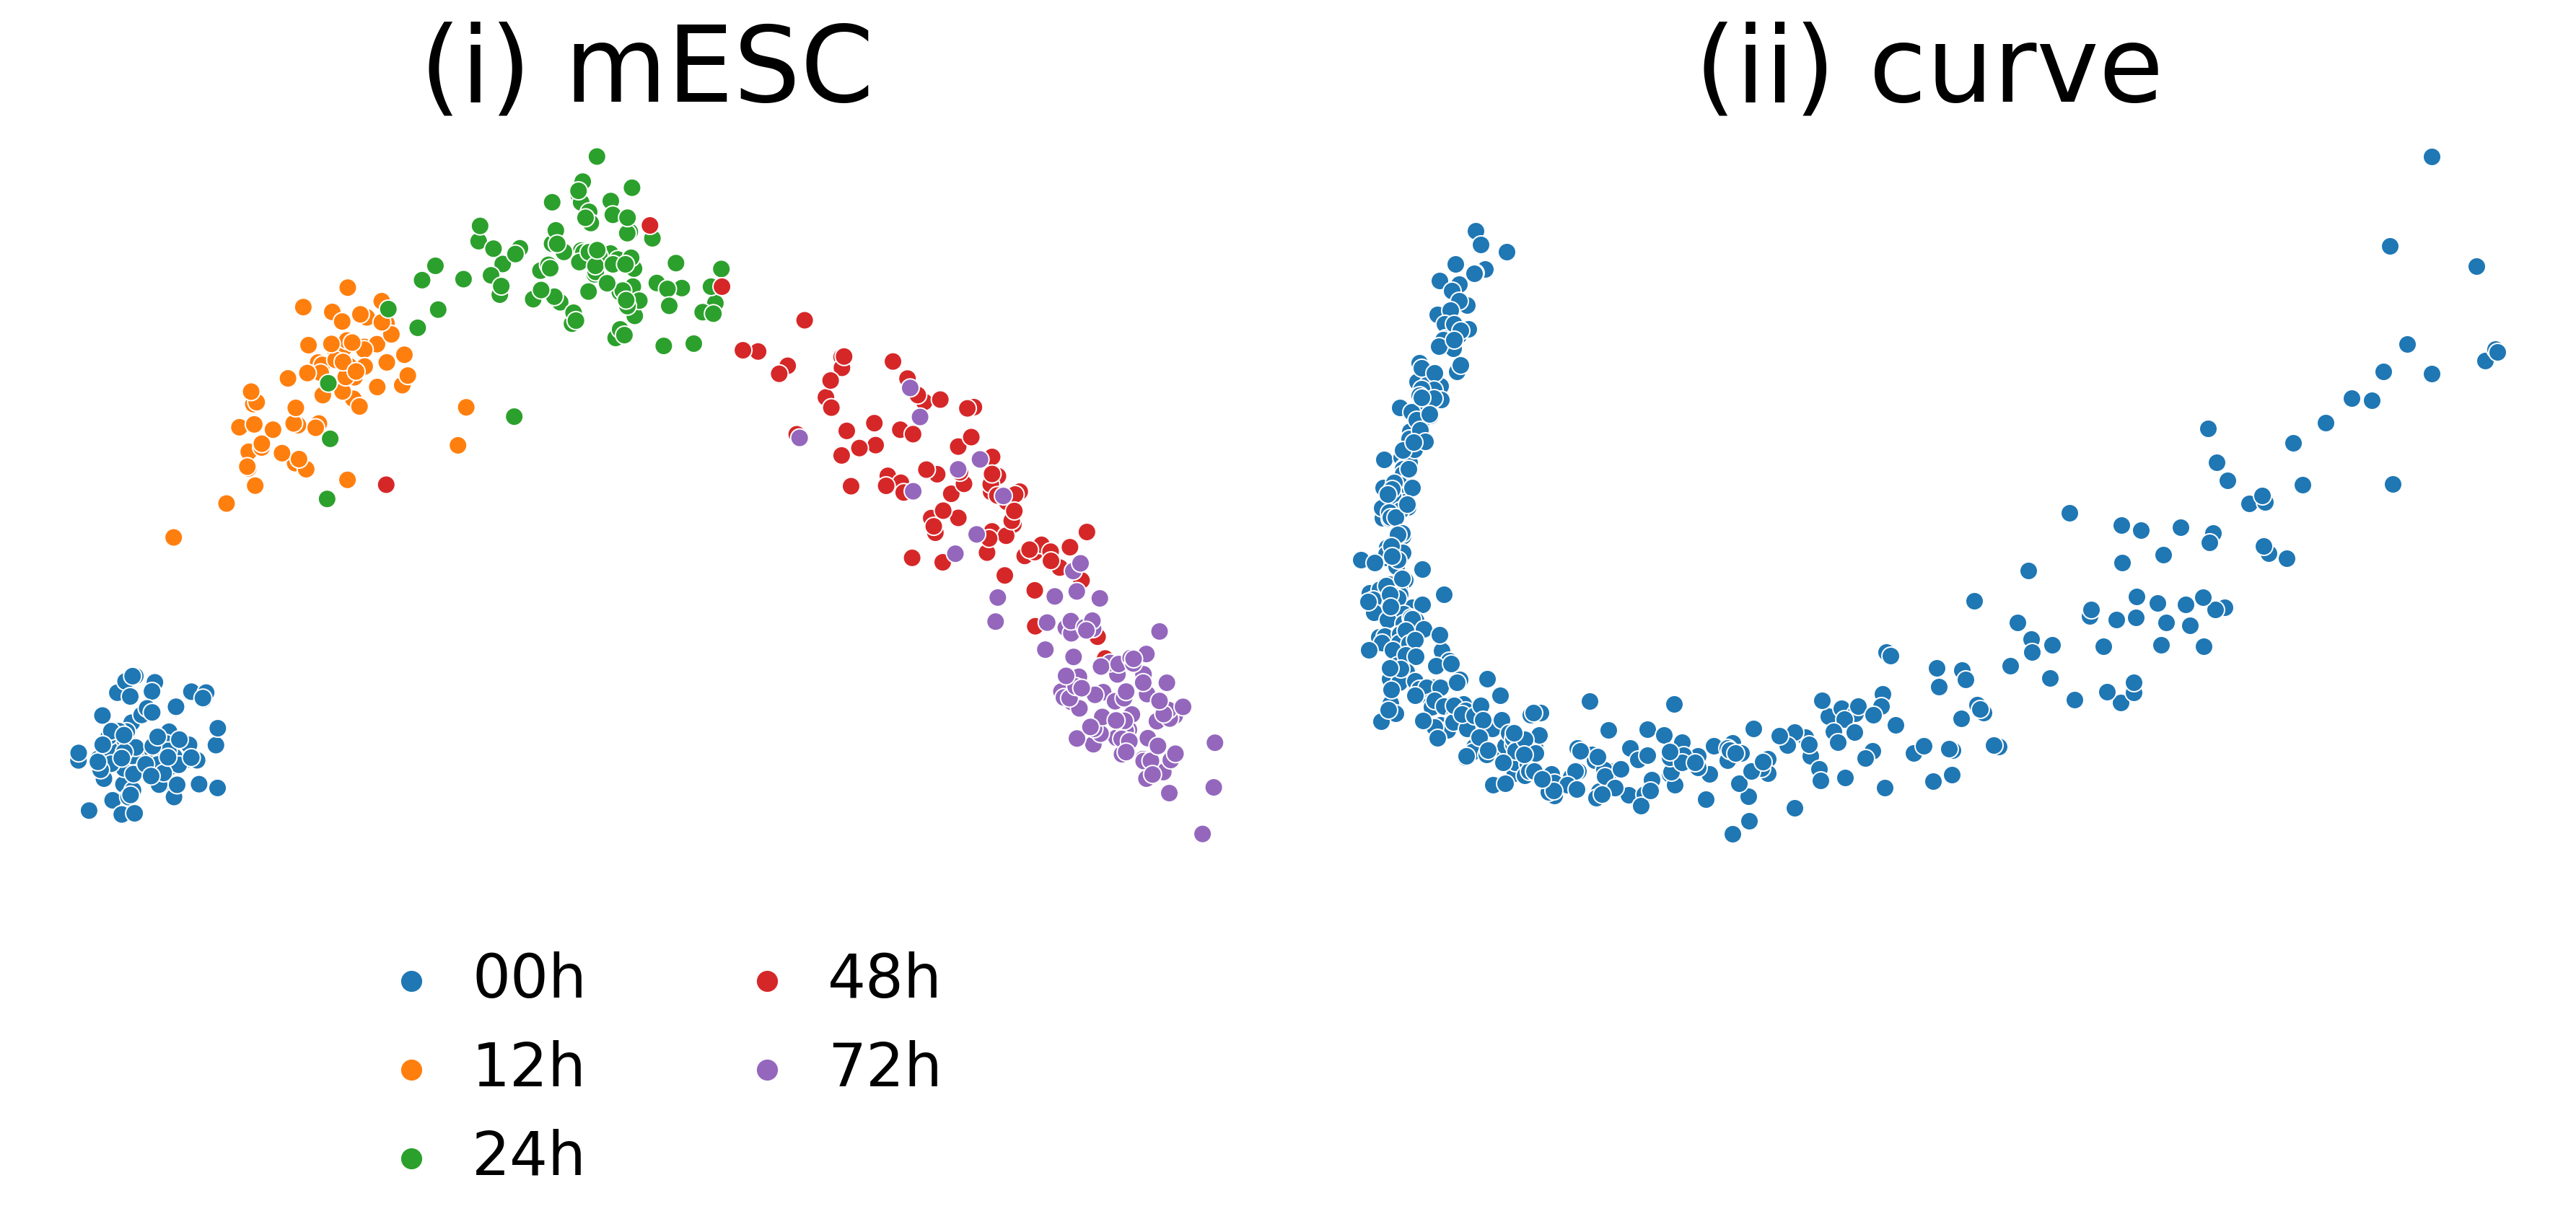

In [5]:
# plot trajectories

# for each, plot colored by branch and pseudotime (also distance from cell 0?)
fig, ax = plt.subplots(**plot_config)


# for itraj, (traj_desc, traj) in enumerate(trajs.items()):
#     tl = plot_loc[traj_desc]
#     palette = palettes[traj_desc]
#     title = traj_fignames[traj_desc]
#     T.pl.plot_pca2d(traj.pX, meta=traj.meta, ax=ax[tl], palette=palette, title=title)

# plot trajectories
for itraj, (traj_desc, traj) in enumerate(trajs.items()):
    title = f'({T.pl.write_roman(itraj + 1).lower()}) {traj_fignames[traj_desc]}'
    T.pl.plot_pca2d(traj.pX, meta=traj.meta, ax=ax[itraj], palette=palettes[traj_desc], title=title)

plt.tight_layout()
if save:
    plt.savefig(os.path.join(outdir, 'fig_trajs.png'), bbox_inches='tight')

In [6]:
exp_desc = 'covariance' # 'covariance' # 
cell_fit = 'sqrt inv pc'
read_fit = 'sqrt inv pt'

# measures to plot
measure_titles = {'Delta0': r'$\Delta$',
                'dmax_psD': r'$max_{kl}{d_{kl}}$', 
                'pt': r'$p_t$',                
                'pc': r'$p_c$',                                
                'nn_dist_psD': r'$\delta$',
                'sqrt inv pt': r'$\frac{1}{\sqrt{p_t}}$', 
                'sqrt inv pc': r'$\frac{1}{\sqrt{p_c}}$',
                'l1': r'$\varepsilon$',
                'ldist': r'$\varepsilon^{dist}$',
                'cov_err': r'$\|C^0 - C\|$',
                }


### Reads downsample (FigS2)
- example of downsample
- Delta(log p_t)
- dij(log p_t) (all?)
- l1(log p_t)

In [7]:
# read L_read
exp_desc = 'pc_err' #'pc_err' #'covariance' # 
L_read_dict = T.io.read_output(datasets, outdir=outdir, sample='reads', exp_desc=exp_desc)

min_log_pt = -8 # TODO: ideally, do not run at the first place...
for traj_desc, L_read in L_read_dict.items():
    L_read_dict[traj_desc] = L_read[L_read['log pt'] > min_log_pt]     


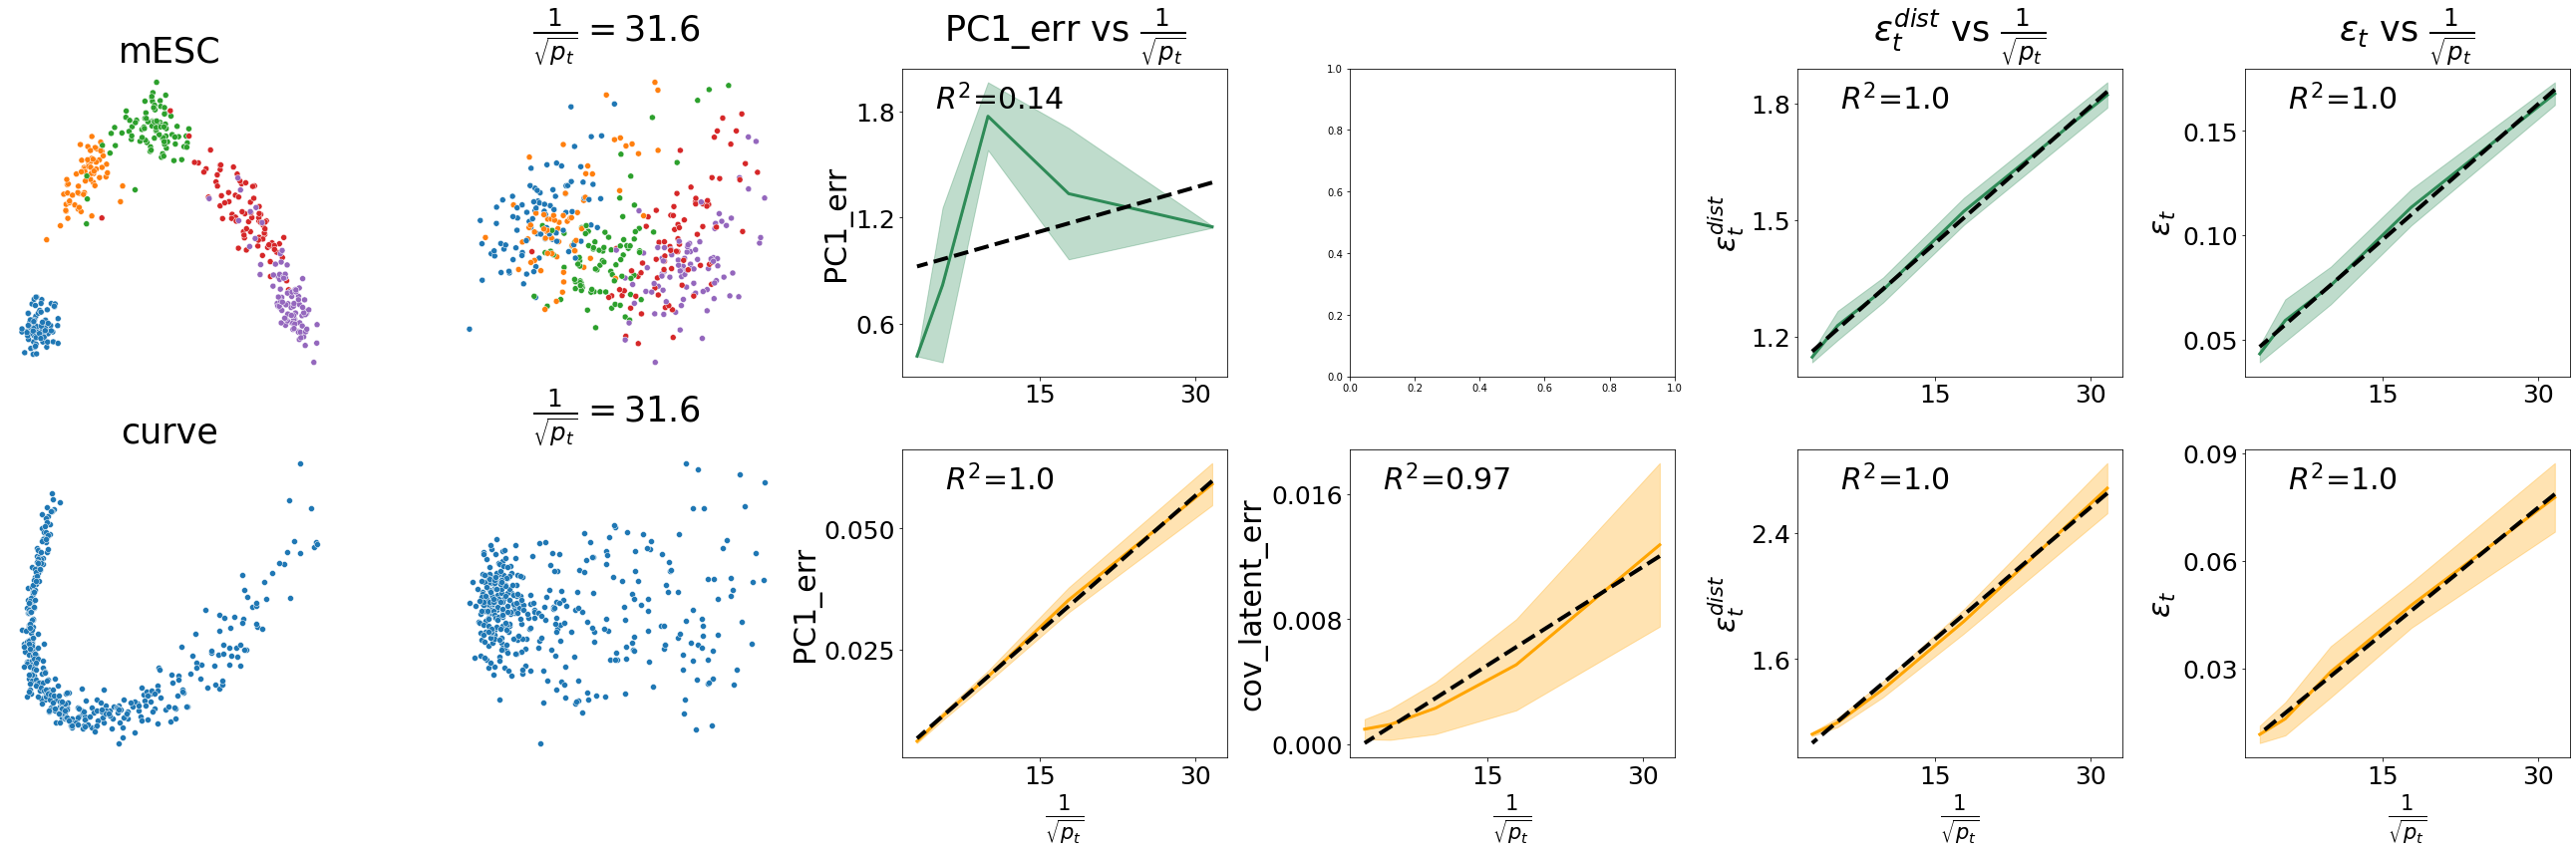

In [9]:
# plot measures
measure_titles['l1'] = r'$\varepsilon_t$'
measure_titles['ldist'] = r'$\varepsilon^{dist}_t$'
plot_std = 1

plot_descs = [ 
    # {'xcol': read_fit, 'ycol': 'cov_err', 'add_fit': True},
    {'xcol': read_fit, 'ycol': 'PC1_err', 'add_fit': True},
    {'xcol': read_fit, 'ycol': 'cov_latent_err', 'add_fit': True},
    # {'xcol': read_fit, 'ycol': 'PC3_err', 'add_fit': True},
    {'xcol': read_fit, 'ycol': 'ldist', 'add_fit': True},
    {'xcol': read_fit, 'ycol': 'l1', 'add_fit': True, 'save_fit': True},
    ]

ntrajs_pl = 2
nfeatures =  ntrajs_pl + len(plot_descs)
fig, ax = plt.subplots(ntrajs, nfeatures, figsize=(6 * nfeatures, 6*ntrajs))
ax = ax.reshape((1,-1)) if len(ax.shape) == 1 else ax

# xcol = 'log pt'; xlabel = r'$log p_t$'
min_pt = 1e-4 #1e-3
groupby='pt'
model_read_dict = {}
for itraj, (traj_desc, L_read) in enumerate(L_read_dict.items()):

    # plot trajectory
    pt = L_read[L_read['pt'] > min_pt]['pt'].min()
    traj = trajs[traj_desc]
    sX, psX, psD, sD, psP, ix,pca = traj.subsample(pc=1, pt=pt)
    palette = palettes[traj_desc]
    stitle = r'$\frac{1}{\sqrt{p_t}}=$' + "{:.1f}".format(1/np.sqrt(pt))
    # stitle = r'$p_t=$' + "{:.1e}".format(pt)
    title = traj_fignames[traj_desc]
    T.pl.plot_pca2d(traj.pX, meta=traj.meta, ax=ax[itraj,0], title=title, legend=False, palette=palette) # true for subsample
    T.pl.plot_pca2d(psX, meta=traj.meta.iloc[ix], ax=ax[itraj,1], title=stitle, legend=False, palette=palette)

    color = colors[traj_desc]

    for ipl, plot_desc in enumerate(plot_descs):
        
        sax = ax[itraj, ntrajs_pl + ipl]
        
        ycol= plot_desc['ycol']; 
        xcol = plot_desc['xcol']; 
        if (xcol in L_read.columns) and (ycol in L_read.columns):
            ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol
            xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol
            
            title = f'{ylabel} vs {xlabel}' if itraj == 0 else ''
            xlabel = xlabel if itraj == (ntrajs - 1) else ''
            
            add_fit = False if 'add_fit' not in plot_desc.keys() else plot_desc['add_fit']
            save_fit = False if 'save_fit' not in plot_desc.keys() else plot_desc['save_fit']
            
            
            model_read = T.pl.plot_tradeoff(L_read, xcol=xcol, ycol=ycol, ylabel=ylabel, xlabel=xlabel, plot_std=plot_std, ax=sax, color_mean=color, color_std=color, 
            title=title, groupby=groupby, add_fit=add_fit)
        
            if save_fit:
                model_read_dict[traj_desc] = model_read
        
plt.tight_layout()

if save:
    plt.savefig(os.path.join(outdir, 'sfig_pt.png'))

## Cell downsample
- example of downsample
- Delta(log p_t)
- dij(log p_t) (all or shortest dist only?)
- l1(log p_t)

In [ ]:
# read cell output
L_cell_dict = T.io.read_output(datasets, outdir=outdir, sample='cells', exp_desc=exp_desc)

min_pc = 0.09# 0.035 # TODO: ideally, do not run at the first place...
for traj_desc, L_cell in L_cell_dict.items():
    L_cell_dict[traj_desc] = L_cell[L_cell['pc'] > min_pc]     


NameError: name 'L_cell_dict' is not defined

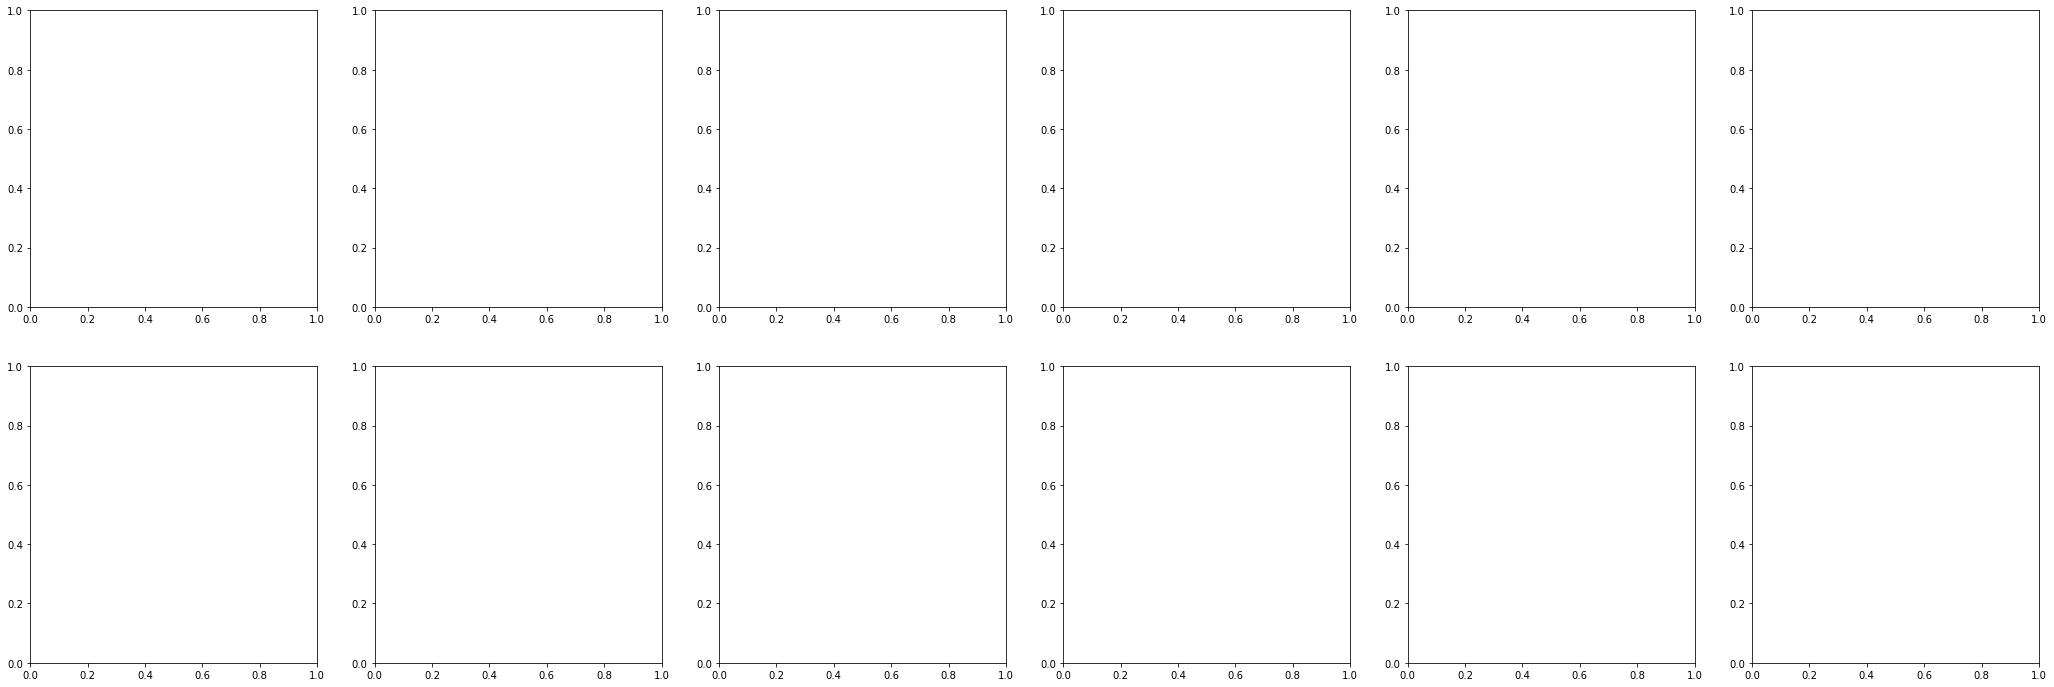

In [10]:
# plot measures
measure_titles['l1'] = r'$\varepsilon_c$'
measure_titles['ldist'] = r'$\varepsilon^{dist}_c$'
plot_std = 1

plot_descs = [ 
    # {'xcol': cell_fit, 'ycol': 'cov_err', 'add_fit': True},
    {'xcol': cell_fit, 'ycol': 'PC1_err', 'add_fit': True},
    {'xcol': cell_fit, 'ycol': 'cov_latent_err', 'add_fit': True},
    {'xcol': cell_fit, 'ycol': 'ldist', 'add_fit': True}, 
    # {'xcol': cell_fit, 'ycol': 'PC3_err', 'add_fit': True}, 
    {'xcol': cell_fit, 'ycol': 'l1', 'add_fit': True, 'save_fit': True},

    ]

ntrajs_pl = 2
nfeatures =  ntrajs_pl + len(plot_descs)
fig, ax = plt.subplots(ntrajs, nfeatures, figsize=(6 * nfeatures, 6*ntrajs))
ax = ax.reshape((1,-1)) if len(ax.shape) == 1 else ax

min_pc = 1e-1
groupby = 'pc'
model_cell_dict = {}
for itraj, (traj_desc, L_cell) in enumerate(L_cell_dict.items()):

    # plot trajectory
    pc = L_cell[L_cell['pc'] > min_pc]['pc'].min()
    traj = trajs[traj_desc]
    sX, psX, psD, sD, psP, ix, pca = traj.subsample(pt=1, pc=pc)
    
    palette = palettes[traj_desc]
    stitle = r'$p_c=$' + "{:.1e}".format(pc)
    title = traj_fignames[traj_desc]
    T.pl.plot_pca2d(traj.pX, meta=traj.meta, ax=ax[itraj,0], title=title, legend=False, palette=palette) # true for subsample
    T.pl.plot_pca2d(psX, meta=traj.meta.iloc[ix], ax=ax[itraj,1], title=stitle, legend=False, palette=palette)

    color = colors[traj_desc]

    for ipl, plot_desc in enumerate(plot_descs):
        sax = ax[itraj, ntrajs_pl + ipl]
        ycol= plot_desc['ycol']; 
        xcol = plot_desc['xcol']; 
        if (xcol in L_cell.columns) and (ycol in L_cell.columns):
            ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol
            xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol

            title = f'{ylabel} vs {xlabel}' if itraj == 0 else ''
            xlabel = xlabel if itraj == (ntrajs - 1) else ''
            
            add_fit = False if 'add_fit' not in plot_desc.keys() else plot_desc['add_fit']
            save_fit = False if 'save_fit' not in plot_desc.keys() else plot_desc['save_fit']
            
            model_cell = T.pl.plot_tradeoff(L_cell, xcol=xcol, ycol=ycol, ylabel=ylabel, xlabel=xlabel, plot_std=plot_std, ax=sax, color_mean=color, color_std=color, 
            title=title, groupby=groupby, add_fit=add_fit)
            
            if save_fit:
                model_cell_dict[traj_desc] = model_cell
        
plt.tight_layout()

if save:
    plt.savefig(os.path.join(outdir, 'sfig_pc.png'))

### figure 1 

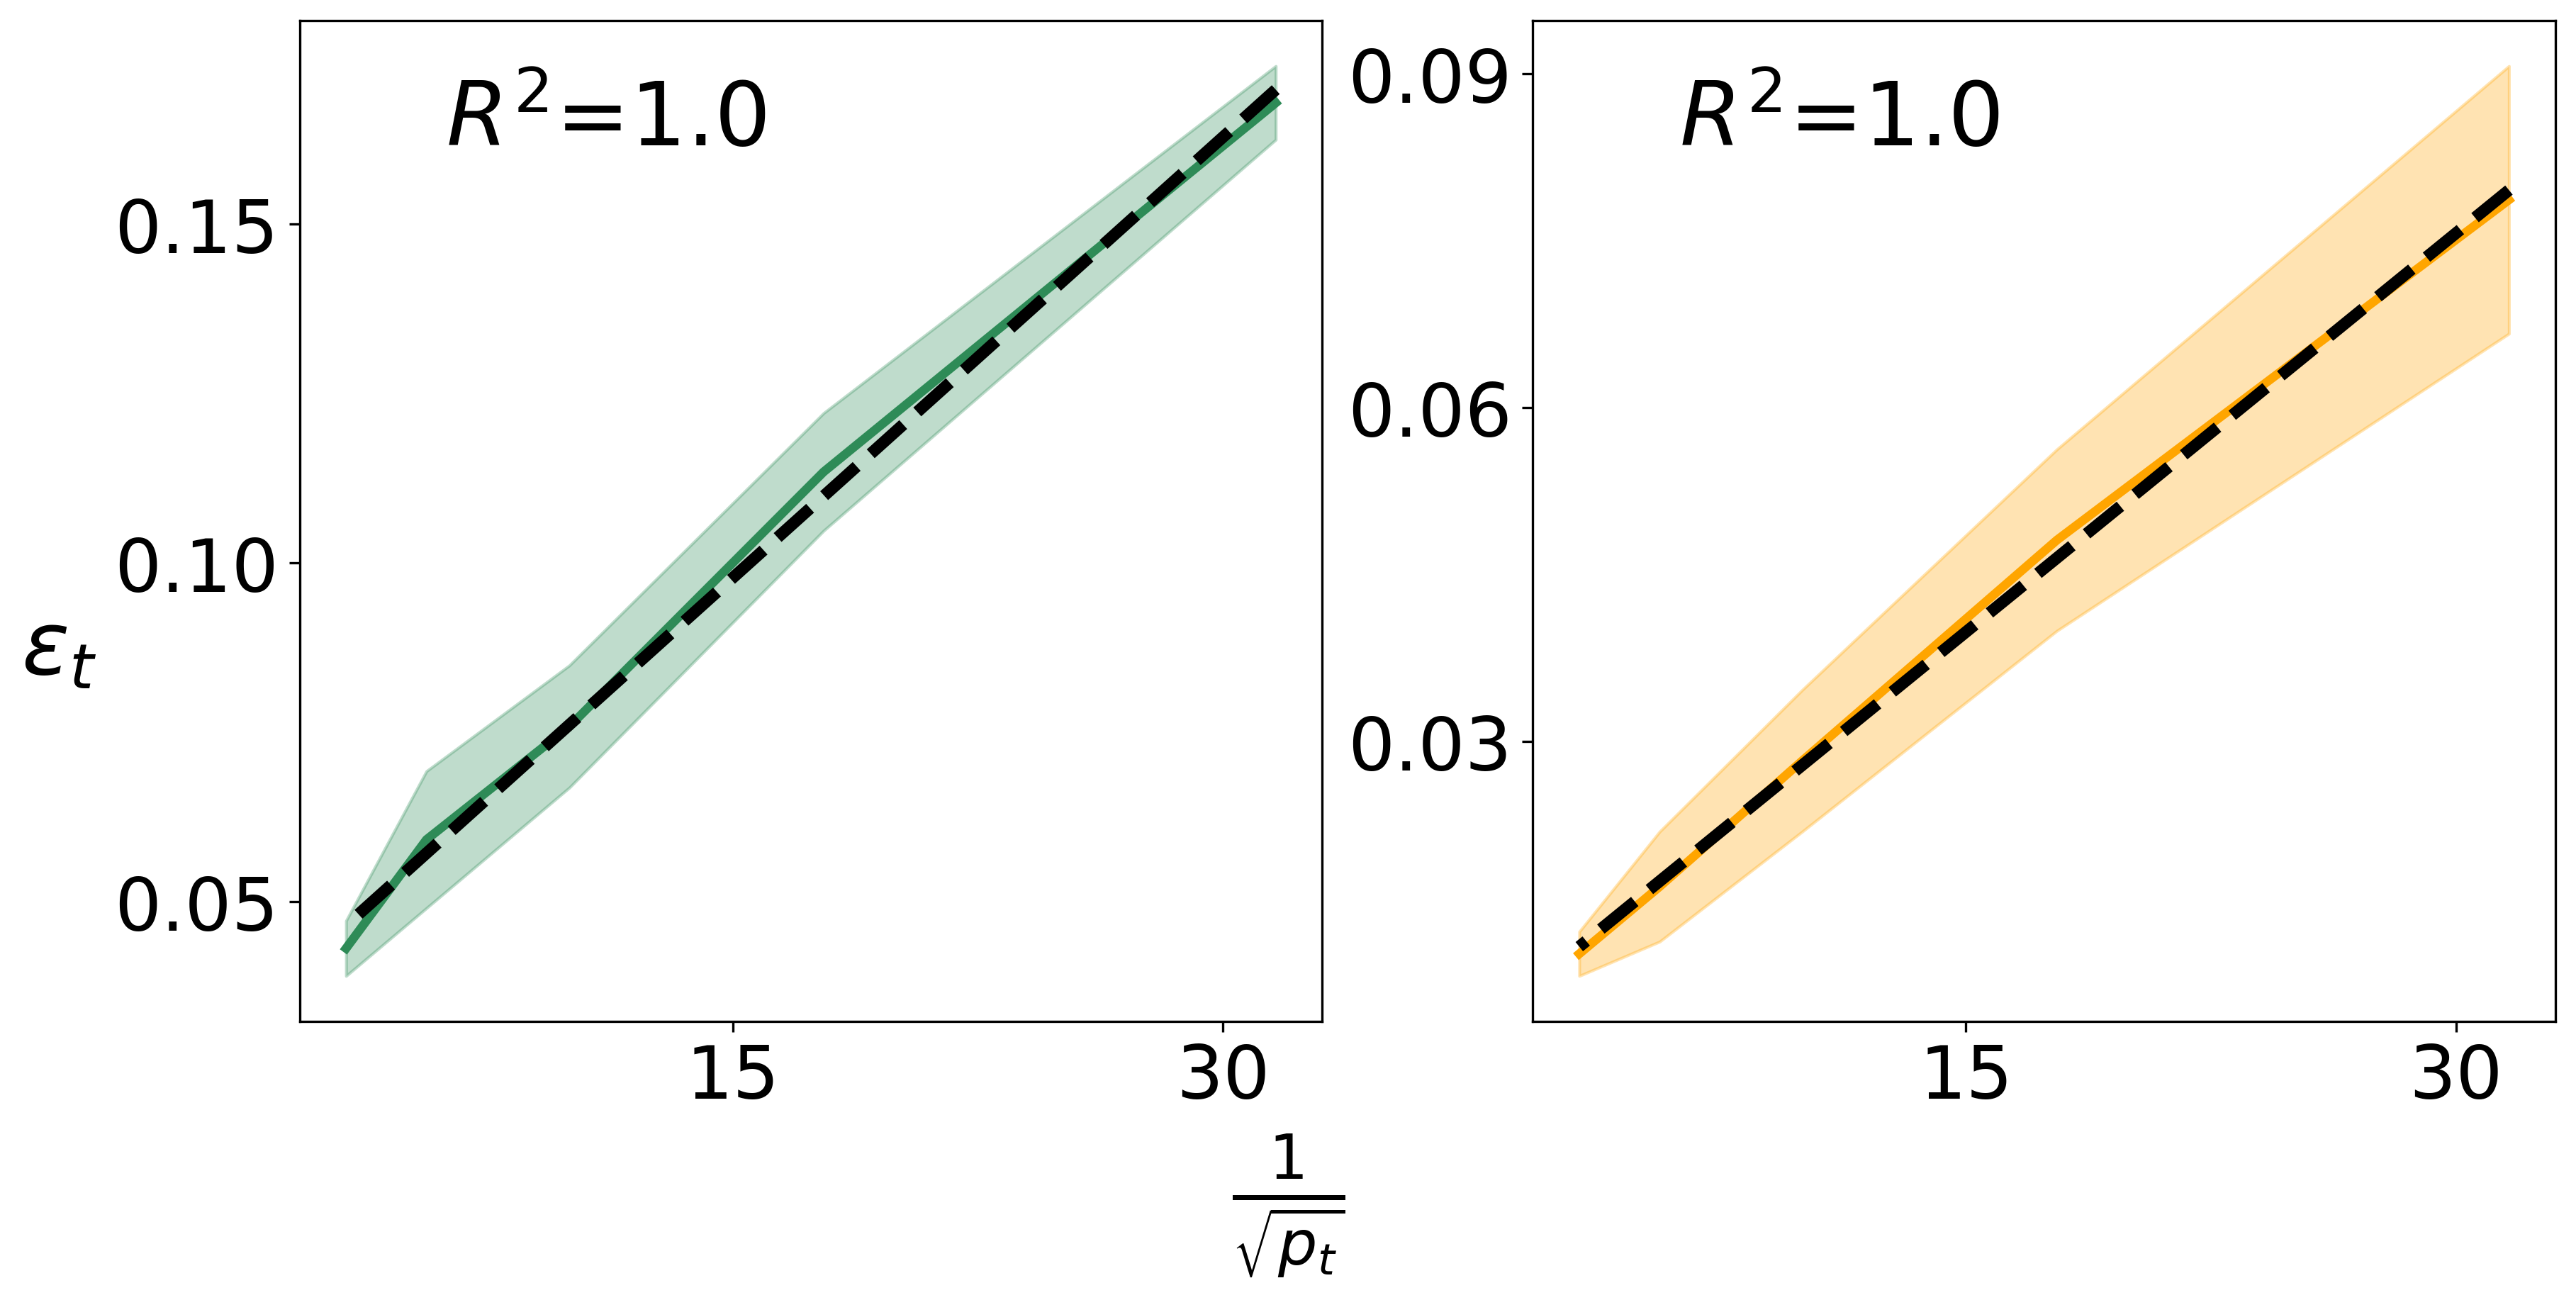

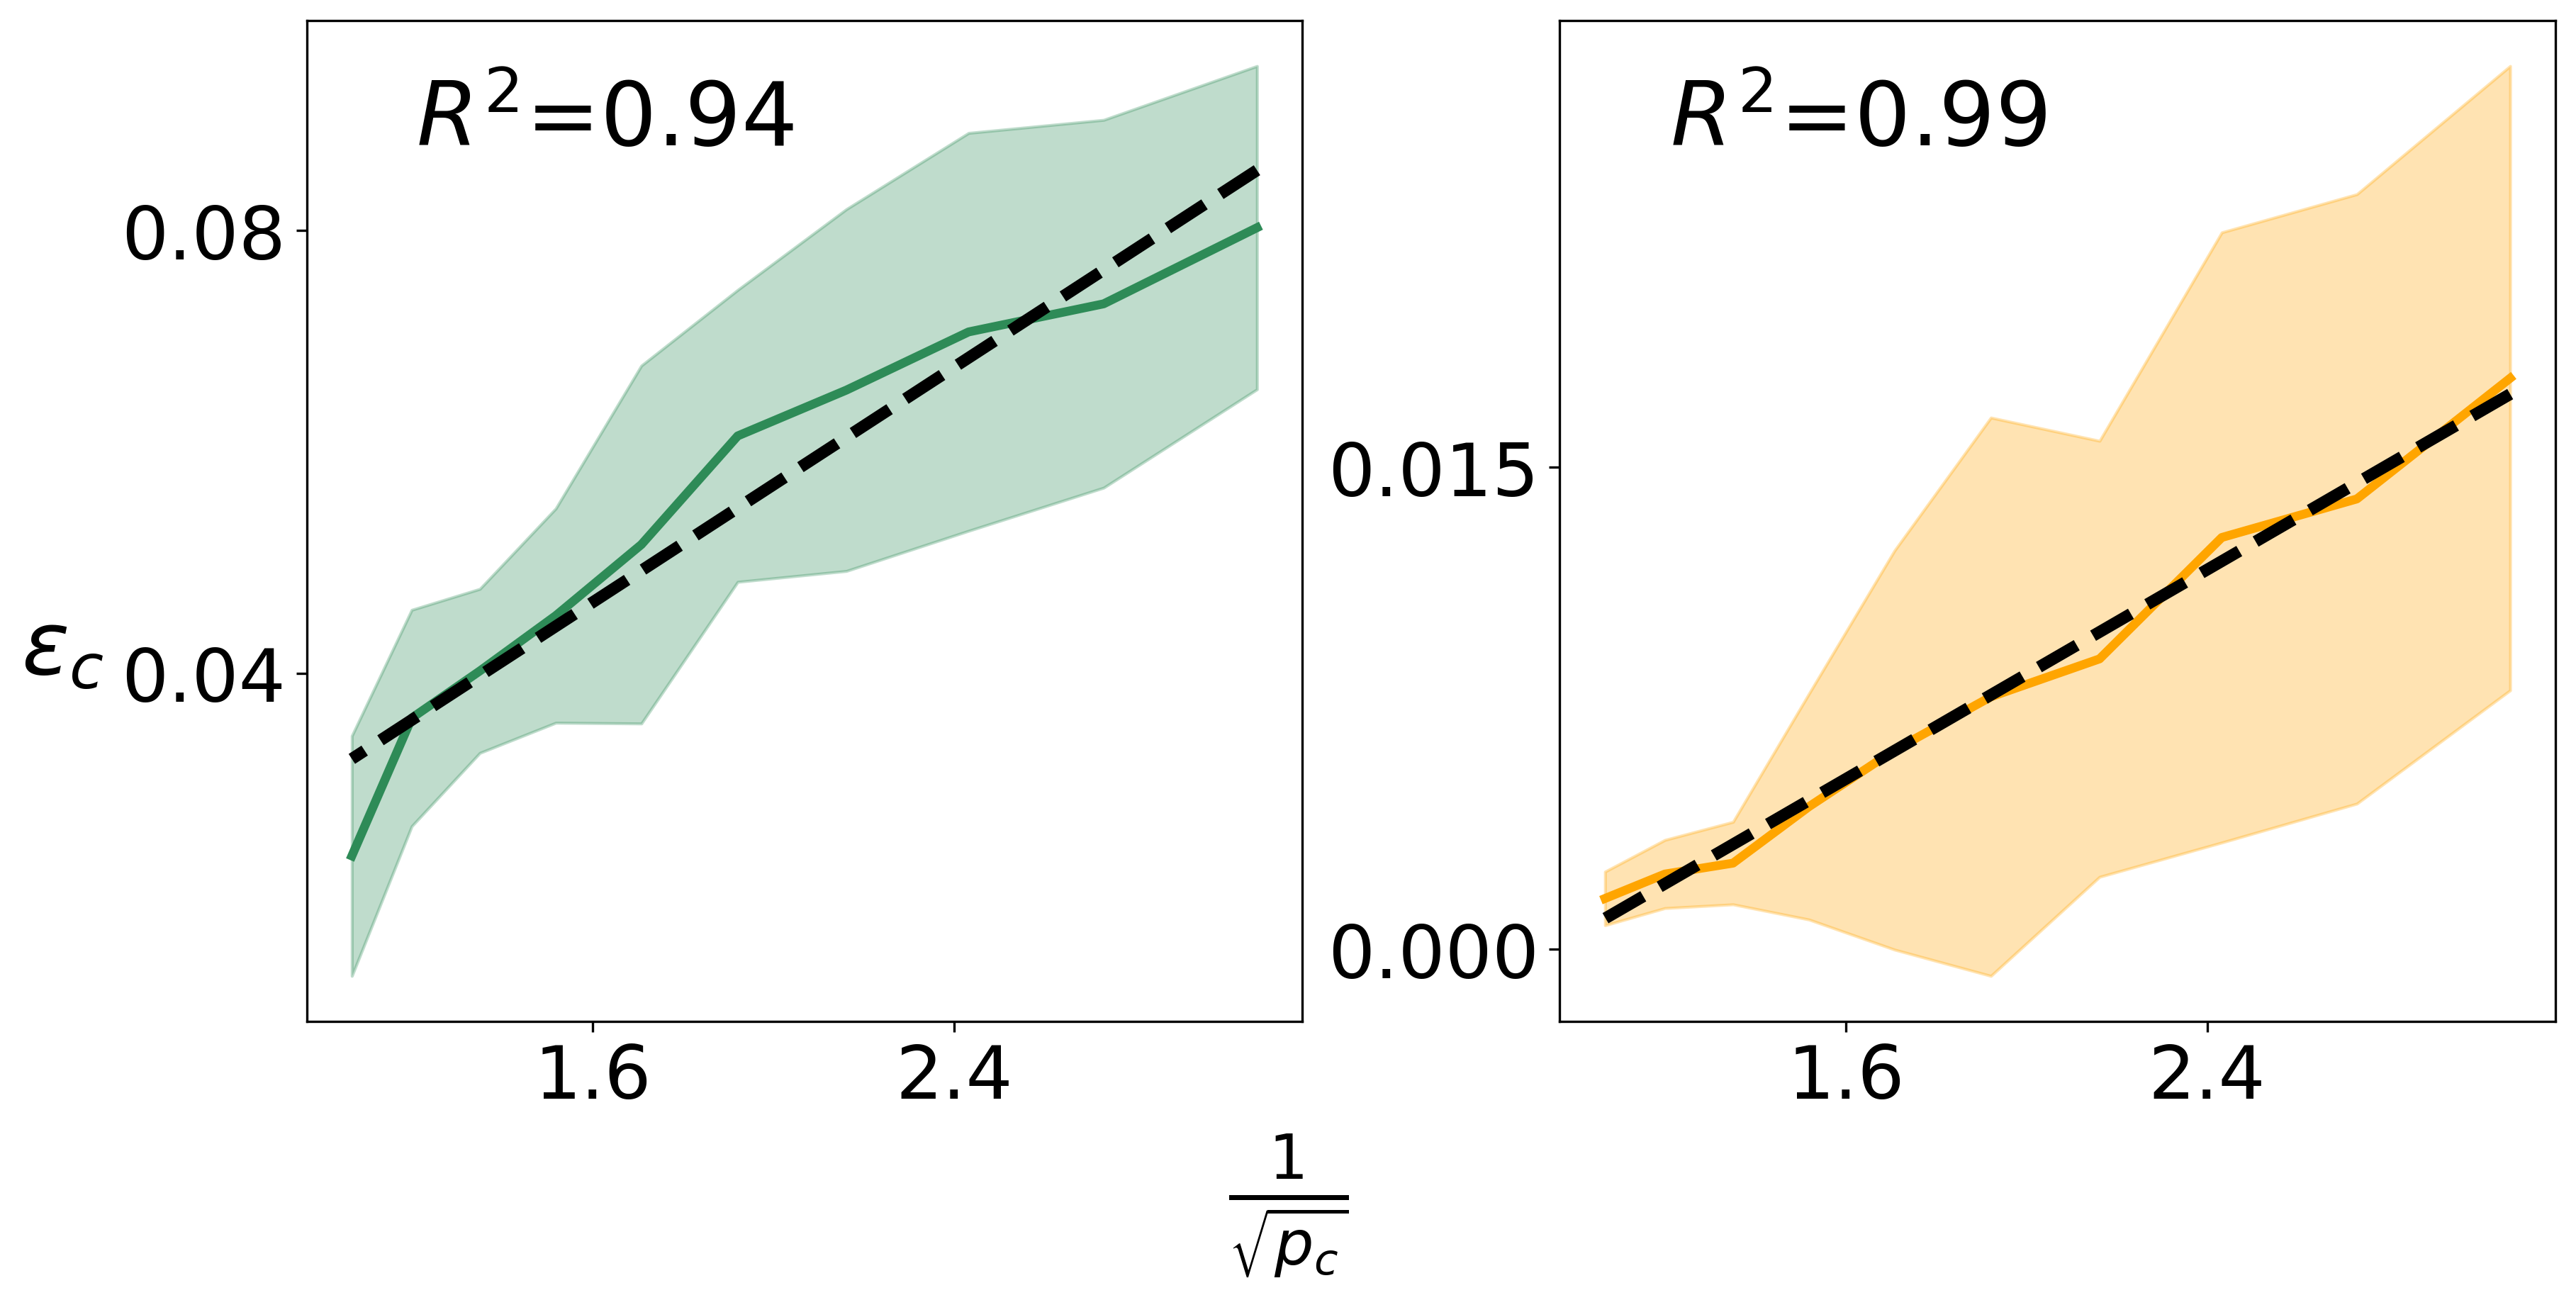

In [ ]:
# FIGURE 1 - trajectories, error with pt, error with pc
plot_std = 1
    
labelsize = 30
titlesize = 30

# plot transcript error
title = ''
# ycol='cov_err'; ylabel = measure_titles[ycol]
ycol='l1'; ylabel = r'$\varepsilon_t$'
xcol = read_fit; xlabel = measure_titles[xcol]
fig, ax = plt.subplots(**plot_config, sharex=True)
for itraj, (traj_desc, L_read) in enumerate(L_read_dict.items()):
    color = colors[traj_desc]
    sax = ax[itraj] # TODO: save here fits?
    _ = T.pl.plot_tradeoff(L_read, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title, add_fit=True)

fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_pt.png'))

# plot cell error
title = ''
# ycol='cov_err'; ylabel = measure_titles[ycol]
ycol='l1'; ylabel = r'$\varepsilon_c$'
xcol = cell_fit; xlabel = measure_titles[xcol]

fig, ax = plt.subplots(**plot_config, sharex=True)
for itraj, (traj_desc, L_cell) in enumerate(L_cell_dict.items()):
    color = colors[traj_desc]
    sax = ax[itraj] # ax[row, itraj]
    _ = T.pl.plot_tradeoff(L_cell, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title, add_fit=True)

fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)            

if save:
    plt.savefig(os.path.join(outdir, 'fig_pc.png'))

## Tradeoff

In [ ]:
# read tradeoff experiments
L_tradeoff_dict = T.io.read_output(datasets, outdir=outdir, sample='tradeoff', exp_desc='')

# TODO: this is temp
for traj_desc, L_tradeoff in L_tradeoff_dict.items():
    L_tradeoff['sqrt inv pc'] = np.sqrt(1/L_tradeoff['pc'])
    L_tradeoff['sqrt inv pt'] = np.sqrt(1/L_tradeoff['pt'])
    L_tradeoff['B'] = np.round(L_tradeoff['B'], 5)
    # L_tradeoff['sqrt inv pt pc'] = np.sqrt(1/(L_tradeoff['pt'] * L_tradeoff['pc']))
    # L_tradeoff = L_tradeoff[L_tradeoff['log pt'] > min_log_pt] # TEMP
    L_tradeoff_dict[dataset] = L_tradeoff

# plot all trajectories before any processing
fig, ax = plt.subplots(**plot_config)
xcol = 'pc'

for traj_desc, L_tradeoff in L_tradeoff_dict.items():
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    T.pl.plot_tradeoff_experiments(L_tradeoff=L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, 
    colors=colors, ylabel='', axs=ax[tl], labelsize=25, xlabel='', ycol='l1')#, title=title)

# smoothing sampling results
rL_tradeoff_dict = {}
roll = 4

for traj_desc, L_tradeoff in L_tradeoff_dict.items():
    rL_tradeoff = T.pl.smooth_tradeoff(L_tradeoff, roll=roll)
    rL_tradeoff['trajectory type'] = L_tradeoff['trajectory type'].iloc[0]
    rL_tradeoff_dict[traj_desc] = rL_tradeoff

L_tradeoff_dict = rL_tradeoff_dict

# budgets
Bs = L_tradeoff['B'].unique()
nBs = len(Bs)


RuntimeError: dictionary changed size during iteration

[8e-05, 0.00022, 0.0006, 0.00167, 0.00464]


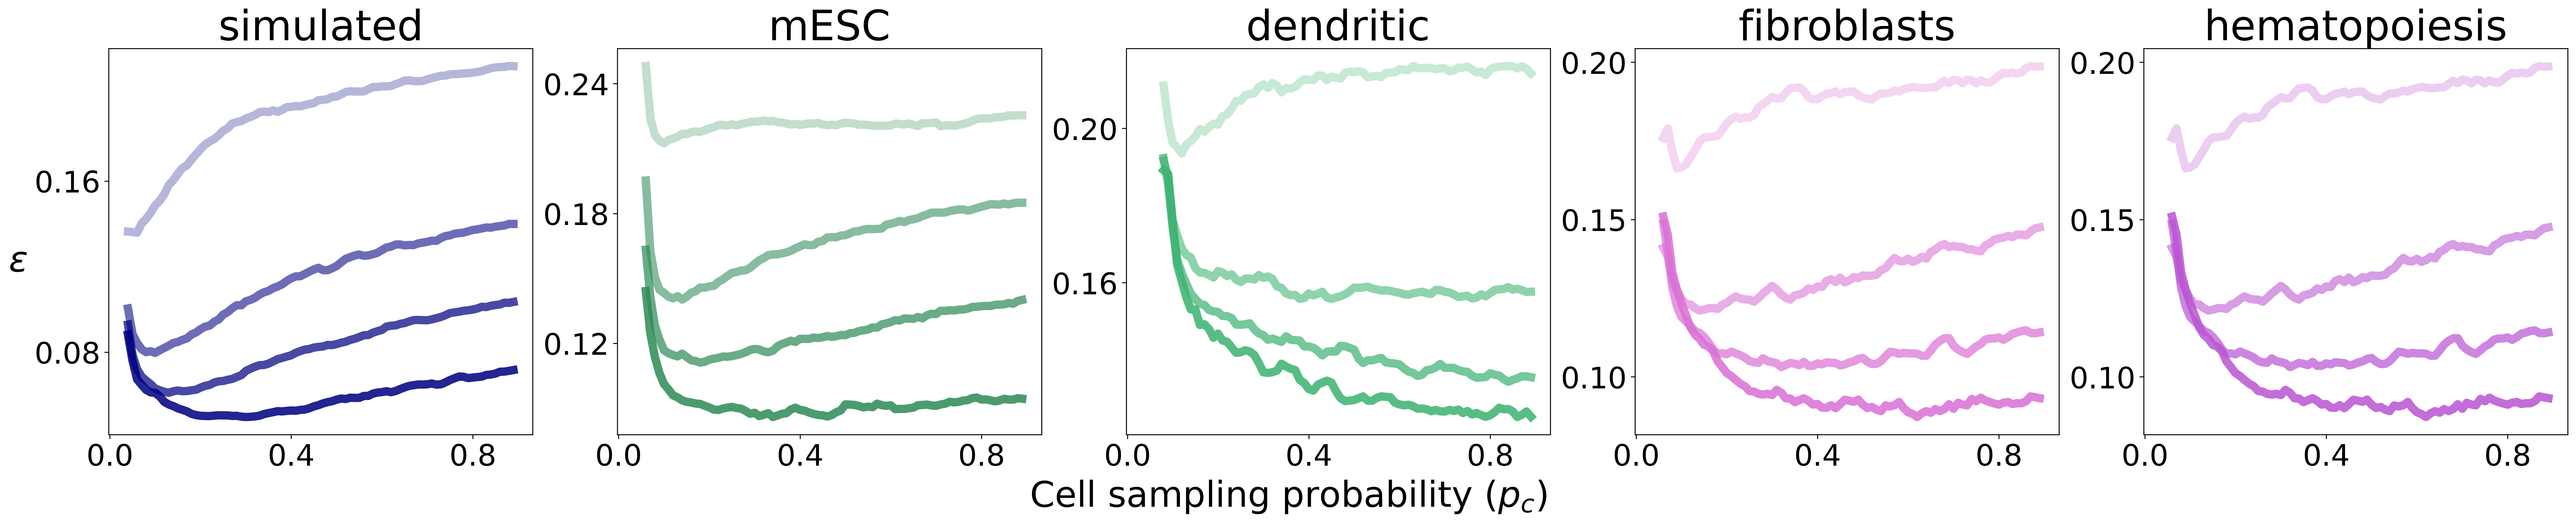

In [ ]:
# plot tradeoff
plot_std = 1
xcol = 'pc'
ycol='l1'; ylabel = r'$\varepsilon$'
fig, ax = plt.subplots(**plot_config, sharex=True) #, constrained_layout=True, tight_layout=False, sharey=True

Bs_pl = [B for B in Bs if (B > 5e-5) and (B < 1e-2)]#[3:7]#[3:-1:2]
nBs_pl = len(Bs_pl)
print(Bs_pl)

for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    color = colors[traj_desc]
    
    for iB,B in enumerate(Bs_pl): #_pl
        sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
        alpha = (iB+2) / (nBs_pl+2) #_pl
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], 
        color_mean=color, color_std=color, alpha=alpha, title=title, linewidth=7)
    
# fig.suptitle('Reconstruction error under constant sequencing budget', fontsize=titlesize)
labelsize = 30
ylabel = r'$\varepsilon$'
xlabel = r'Cell sampling probability ($p_c$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_curves.png'))

In [ ]:
# # plotting empirically monotonic increasing/decreasing
# plot_std = 0
# xcol = 'pc'
# color_cell_better = 'black'
# color_read_better = 'darkslategray'
# fig, ax = plt.subplots(**plot_config)
# min_seq_locations = 1
# min_diff = 1e-3

# kwargs = {'plot_std': plot_std,
#          'plot_pc_opt': False,
#          'sharey': False,
#          'plot_pcs': False,
#          'xcol': xcol,
#          'xlabel': '',
#          'ylabel': '',
#          }

# for dataset, L_tradeoff in L_tradeoff_dict.items():
#     tl = plot_loc[dataset]
#     L_grp = L_tradeoff.groupby(['B'])

#     for B, sL in L_grp:
#         if B in Bs_pl:
#             vals = T.pl.check_increase_decrease(sL['pc'], sL['l1'], min_seq_locations=min_seq_locations, min_diff=min_diff)

#             is_decreasing = 'decreasing' in vals
#             is_increasing = 'increasing' in vals
#             if is_increasing and not is_decreasing:
#                 T.pl.plot_tradeoff_experiments(L_tradeoff=sL, color=color_cell_better, axs=ax[tl], **kwargs)
#             elif not is_increasing and is_decreasing:
#                 T.pl.plot_tradeoff_experiments(L_tradeoff=sL, color=color_read_better, axs=ax[tl], **kwargs)
#             elif is_increasing and is_decreasing:
#                 T.pl.plot_tradeoff_experiments(L_tradeoff=sL, colors=colors, axs=ax[tl], **kwargs)
#             else:
#                 print('Neither')

# # plt.suptitle('Tradeoff ')

## Modeling reconstruction error

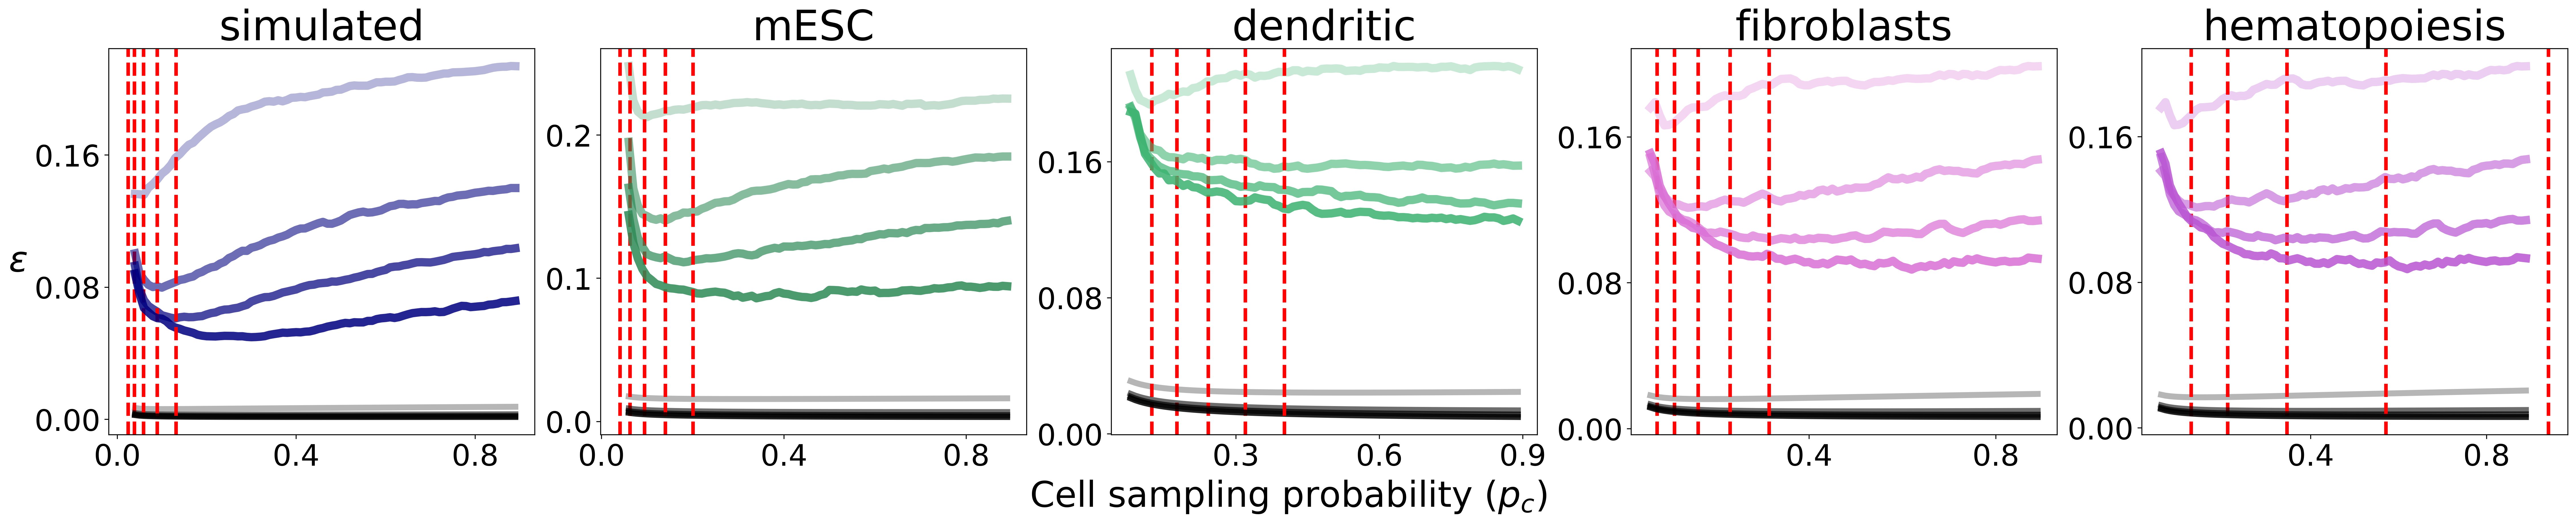

In [ ]:
# predict curve from cell/read models
plot_std = 1
xcol = 'pc' #cell_fit #'log pc'
fig, ax = plt.subplots(**plot_config,) # sharex=True, sharey=True
pred_cell_col = 'pred cell l1' # 'pred cell l1'
pred_read_col = 'pred read l1'

B_min = 0.0001

color_cell = 'orange'
color_read = 'brown'

corr_list = []

for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    color = colors[traj_desc]

    model_read = model_read_dict[traj_desc]
    model_cell = model_cell_dict[traj_desc]
    
    L_tradeoff[pred_cell_col] = model_cell.predict(L_tradeoff[[cell_fit]])
    L_tradeoff[pred_read_col] = model_read.predict(L_tradeoff[[read_fit]])

    # c = L_tradeoff['l1'].max() / L_tradeoff['sqrt inv pt pc'].max()
    # L_tradeoff['scaled sqrt inv pt pc'] = L_tradeoff['sqrt inv pt pc'] * c
    # L_tradeoff['pred l1'] = L_tradeoff['sqrt inv pt pc'] # constant since budget is constant
    L_tradeoff['pred l1'] = L_tradeoff[pred_cell_col] * L_tradeoff[pred_read_col]
    # L_tradeoff['pred l1'] = L_tradeoff[pred_cell_col] + L_tradeoff[pred_read_col]
    # L_tradeoff['pred l1'] = L_tradeoff.apply(lambda row: T.opt.softmax_max((row[pred_cell_col], row[pred_read_col]), a=20), axis=1) 
    # L_tradeoff['pred l1'] = L_tradeoff.apply(lambda row: np.max((row[pred_cell_col], row[pred_read_col])), axis=1) 
    # L_tradeoff['pred l1'] = np.maximum(L_tradeoff[pred_cell_col], L_tradeoff[pred_read_col])


    for iB,B in enumerate(Bs_pl): #TODO: change back
        sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
        alpha_col = (iB+2) / (nBs_pl+2)

        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean=color, color_std=color, 
        alpha=alpha_col, title=title, linewidth=7)
        
        # T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=pred_cell_col, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], 
        # color_mean=color_cell, linewidth=7)
        
        # T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=pred_read_col, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], 
        # color_mean=color_read, linewidth=7)

        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol='pred l1', ylabel='', xlabel='', ax=ax[tl], color_mean='black', color_std=color, 
        alpha=alpha_col, title=title, linewidth=5)
        
        corr = np.corrcoef(sL_tradeoff['l1'], sL_tradeoff['pred l1'])[0,1]
        corr_list.append(corr)
        # print(corr)
        
        pc_min_pred = T.opt.get_pc_min_pred(model_read=model_read, model_cell=model_cell, B=B)
        ax[tl].axvline(x=pc_min_pred, color='red', linewidth=3, linestyle='--')
        
    
    

labelsize = 30
ylabel = r'$\varepsilon$'
xlabel = r'Cell sampling probability ($p_c$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_curves_pred.png'))

# plt.hist(corr_list); plt.title(f'Average corr: {np.mean(corr_list)}')

In [ ]:
pc_min_pred

0.941129113591729

Text(0.5, 1.0, 'Average corr: nan')

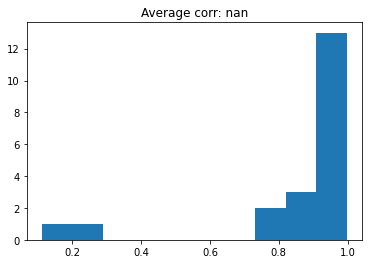

In [ ]:
plt.hist(corr_list, bins=10); plt.title(f'Average corr: {np.mean(corr_list)}')

TypeError: only integer scalar arrays can be converted to a scalar index

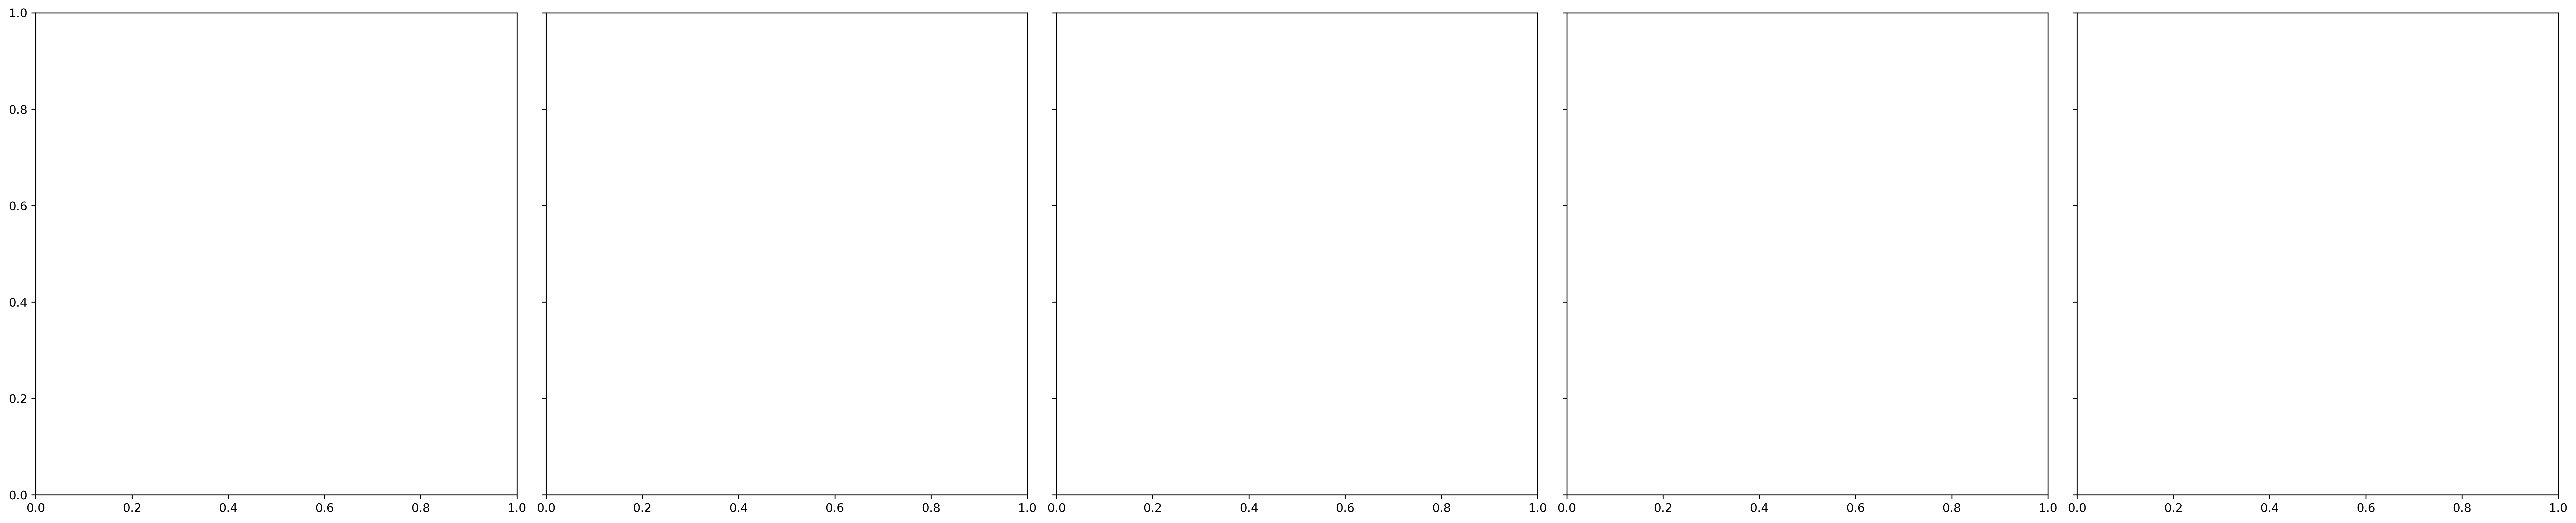

In [ ]:
# predict curve through fitting
plot_std = 1
xcol = 'pc' 
fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True)
pred_cell_col = 'pred cell l1' # 'pred cell l1'
pred_read_col = 'pred read l1'

corr_list = []
nfit = 2
for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    color = colors[traj_desc]

    df_pred = T.opt.fit_reconstruction_err(L_tradeoff[L_tradeoff['B'].isin(Bs_pl[-nfit:])])

    for iB,B in enumerate(Bs_pl[-nfit:]): #TODO: change back
        sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
        alpha_col = (iB+2) / (nBs_pl+2)

        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean=color, color_std=color, 
        alpha=alpha_col, title=title, linewidth=7)
        
        # sL_tradeoff['pred l1 fit'] = T.opt.fit_reconstruction_err(sL_tradeoff)
        sdf_pred = df_pred[df_pred['B'] == B]
        T.pl.plot_tradeoff(sdf_pred, xcol=xcol, ycol='pred l1 fit', ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean='black', color_std=color, 
        alpha=alpha_col, title=title, linewidth=5)
        
        # corr = np.corrcoef(sL_tradeoff['l1'], sL_tradeoff['pred l1 fit'])[0,1]
        # corr_list.append(corr)
        
labelsize = 30
ylabel = r'$\varepsilon$'
xlabel = r'Cell sampling probability ($p_c$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_curves_pred_fit.png'))

# plt.hist(corr_list); plt.title(f'Average corr: {np.mean(corr_list)}')

In [ ]:
# from scipy.optimize import curve_fit

# def fit_reconstruction_err(L):
#     """
#     Fit each reconstruction error curve by:
#     \varepsilon = b * (x2/x1) + beta * x1 +c
#     where x1 corresponds to 1/sqrt(pc) and x2 corresponds to sqrt(B)
#     """
#     ntrajs = L['trajectory type'].value_counts().shape[0] if 'trajectory type' in L.columns else 0
#     if (ntrajs > 1):
#         print(f'Computes fit of a single trajectory. Data seems to include: {ntrajs} trajectories.')
    
#     gL = L.groupby(['B','pc']).mean().reset_index()
    
#     # def cov_err(X, b, beta, c):
#     #     x1,x2 = X
#     #     y = b*(x2/x1) + beta*x1 + c
#     #     return y

#     def cov_err(X, b, beta, a, alpha):
#         x1,x2 = X
#         y = np.maximum(b*(x2/x1) + a, beta*x1 + alpha)
#         # y = T.opt.softmax_max(b*(x2/x1) + a, beta*x1 + alpha)
#         return y

#     xdata1 = gL['sqrt inv pc'].values
#     xdata2 = np.sqrt(gL['B'].values)
#     xdata = (xdata1, xdata2)
#     ydata = gL['l1'].values
#     parameters, _ = curve_fit(cov_err, xdata, ydata)

#     ydata_hat = cov_err(xdata, *parameters)
    
#     # plt.plot(xdata, ydata, 'o', label='data')
#     # plt.plot(xdata, ydata_hat, '-', label='fit')
    
#     gL['pred l1 fit'] = ydata_hat
#     return gL


In [ ]:
# plot prediction and actual of tradeoff features
# x axis - B, y axis - pc
# mark boundaries where we predict monotonic and where actually found to be monotonic (monotonic score?)
# point where we predict minimum to be and where min is empirically at


Can see that looking at the max error does not combine well the errors. 

## Directly fitting tradeoff curves with model

In [ ]:
# import numpy as np
# from scipy.optimize import curve_fit

# def pred_l1_func(logpc_logpt, a,b,c):
#     logpc, logpt = logpc_logpt
#     return np.maximum(a*logpc, c*logpt) + b

# # plot tradeoff
# plot_std = 0
# xcol = 'pc'
# fig, ax = plt.subplots(**plot_config)
# pred_cell_col = 'pred cell l1' # 'pred cell l1'
# pred_read_col = 'pred read l1'

# # p0 = 0.1,0.1,0.1

# for itraj, (dataset, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
#     tl = plot_loc[dataset]
#     T.pl.plot_tradeoff_experiments(L_tradeoff=L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, colors=colors, axs=ax[tl])
    
#     logpc_logpt = (L_tradeoff['log pc'].values, L_tradeoff['log pt'].values)
#     l1 = L_tradeoff['l1'].values

#     model_read = model_read_dict[dataset]
#     model_cell = model_cell_dict[dataset]
    
#     a = model_cell.coef_.take(0)
#     b = model_cell.intercept_.take(0)
#     c = model_read.coef_.take(0)
    
#     p0 = a,b,c
#     res = curve_fit(pred_l1_func, logpc_logpt, l1, p0)
#     L_tradeoff['pred l1 model'] = pred_l1_func(logpc_logpt, *res[0])

#     T.pl.plot_tradeoff_experiments(L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol='pc', ycol='pred l1 model', axs=ax[tl])
    
# plt.suptitle(r'Fitted as a $\max(a*\log(p_t), b*\log(p_c)) + c$')
# plt.tight_layout()



# # logpc_logpt = (L_tradeoff['log pc'].values, L_tradeoff['log pt'].values)
# # l1 = L_tradeoff['l1'].values

# # # initial guesses for a,b,c,d,e
# # a = model_cell.coef_.take(0)
# # b = model_cell.intercept_.take(0)
# # c = model_read.coef_.take(0)
# # d = model_read.intercept_.take(0)
# # e = 0.0001
# # # p0 = a,b,c,d,e
# # # p0 = a,b,c #,d,e
# # p0 = 0.1,0.1,0.1
# # print(p0)

# # res = curve_fit(pred_l1_func, logpc_logpt, l1, p0)
# # L_tradeoff['pred l1 model'] = pred_l1_func(logpc_logpt, *res[0])

# # fig,ax = plt.subplots(1,1, figsize=(6,6))
# # T.pl.plot_tradeoff_experiments(L_tradeoff=L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, colors=colors, axs=ax)



# # T.pl.plot_tradeoff_experiments(L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol='pc', ycol='pred l1 model', axs=ax)
    

In [ ]:
# # color differently budgets that demonstrate a tradeoff and those that don't
# plot_std = 0
# xcol = 'pc'
# color_cell_better = 'indianred'
# color_read_better = 'darkslateblue'
# fig, ax = plt.subplots(**plot_config)
# # fig, ax = plt.subplots(2, two_ncols, figsize=(6*two_ncols, 2*6))
# # min_seq_locations = 2
# # pc_min = 0.00001
# # pc_max = 0.99999
# for dataset, L_tradeoff in L_tradeoff_dict.items():

#     tl = plot_loc[dataset]

#     model_read = model_read_dict[dataset]
#     model_cell = model_cell_dict[dataset]

#     a = model_read.intercept_.take(0)
#     b = model_read.coef_.take(0)
#     alpha = model_cell.intercept_.take(0)
#     beta = model_cell.coef_.take(0)

#     # A = (a - alpha) / b
#     # C = (beta + b) / b

#     print(rf'a: {a}, b: {b}, $\alpha$: {alpha}, $\beta$: {beta}')

#     L_grp = L_tradeoff.groupby(['B'])

#     # nc = trajs[dataset].ncells
#     # # pc_min = 1e-4; pc_max = 1 - pc_min
#     # pc_min = 20 / nc; pc_max = 1 - pc_min
#     pc_min = L_tradeoff['pc'].min()
#     pc_max = L_tradeoff['pc'].max()
#     # B_low = np.exp(((beta+b) * np.log(pc_min) + a - alpha) / b)
#     B_low = np.exp(A)*pc_min**C
#     # B_high = np.exp(((beta+b) * np.log(pc_max) + a - alpha) / b)
#     B_high = np.exp(A)*pc_max**C
    
#     print(f'Blow: {B_low}, Bhigh: {B_high}')

#     for B, sL in L_grp:
#         # vals = check_increase_decrease(sL['pc'], sL['l1'], min_seq_locations=min_seq_locations)
        
#         # better_et = (sL['pred cell l1'] > sL['pred read l1']).all()
#         # better_ec = (sL['pred read l1'] > sL['pred cell l1']).all()
#         better_et = B > B_high
#         better_ec = B < B_low

#         # T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, ycol='pred cell l1', color='red', axs=ax[tl])
#         # T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, ycol='pred read l1', color='lime', axs=ax[tl])
        
#         if better_ec:
#             T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, color=color_cell_better, axs=ax[tl])
#         elif better_et:
#             T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, color=color_read_better, axs=ax[tl])
#         else:
#             T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, colors=colors, axs=ax[tl])
            
#             A = -(a-alpha)/(beta+b)
#             C = b / (beta+b)
#             pc_min_pred = np.exp(A)*np.power(B, C)
#             ax[tl].axvline(x=pc_min_pred, color='black', linewidth=3, linestyle='--')
# # L_grp = L_tradeoff.groupby(['B'])

# # for B, sL in L_grp:
# #     vals = check_increase_decrease(sL['pc'], sL['l1'], min_seq_locations=min_seq_locations)

# #     is_decreasing = 'decreasing' in vals
# #     is_increasing = 'increasing' in vals
# #     if is_increasing and not is_decreasing:
# #         T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, color=color_cell_better, axs=ax[tl])
# #     elif not is_increasing and is_decreasing:
# #         T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, color=color_read_better, axs=ax[tl])
# #     elif is_increasing and is_decreasing:
# #         T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, colors=colors, axs=ax[tl])
# #     else:
# #         print('Neither')

# plt.suptitle('Tradeoff')
# plt.tight_layout()

In [ ]:
def compute_emp_min(L_tradeoff):
    """
    Computes the empirical pc the minimizes the reconstruction error
    """
    L_by_B = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))#.mean()
    emp_min = []
    for B, sL_by_B in L_by_B:
        sL_by_B_pc = sL_by_B.groupby('pc')['l1'].mean().reset_index()
        idxmin = sL_by_B_pc['l1'].idxmin()
        pc = sL_by_B_pc.loc[idxmin, 'pc']
        l1 = sL_by_B_pc.loc[idxmin, 'l1']
        emp_min.append({'B':B, 'pc':pc, 'l1':l1})
        
    emp_min = pd.DataFrame(emp_min)
    return emp_min

def compute_pred_cell_greater(L_tradeoff):
    df = L_tradeoff.groupby(['B','pc']).mean().reset_index()
    predcol = 'Greater cell error predicted'
    df[predcol] = (df['pred cell l1'] > df['pred read l1']).astype(int)
    # df[predcol] = np.log(df['pred cell l1'] / df['pred read l1'])
    result = df.pivot(columns='pc', index='B', values=predcol)
    return result

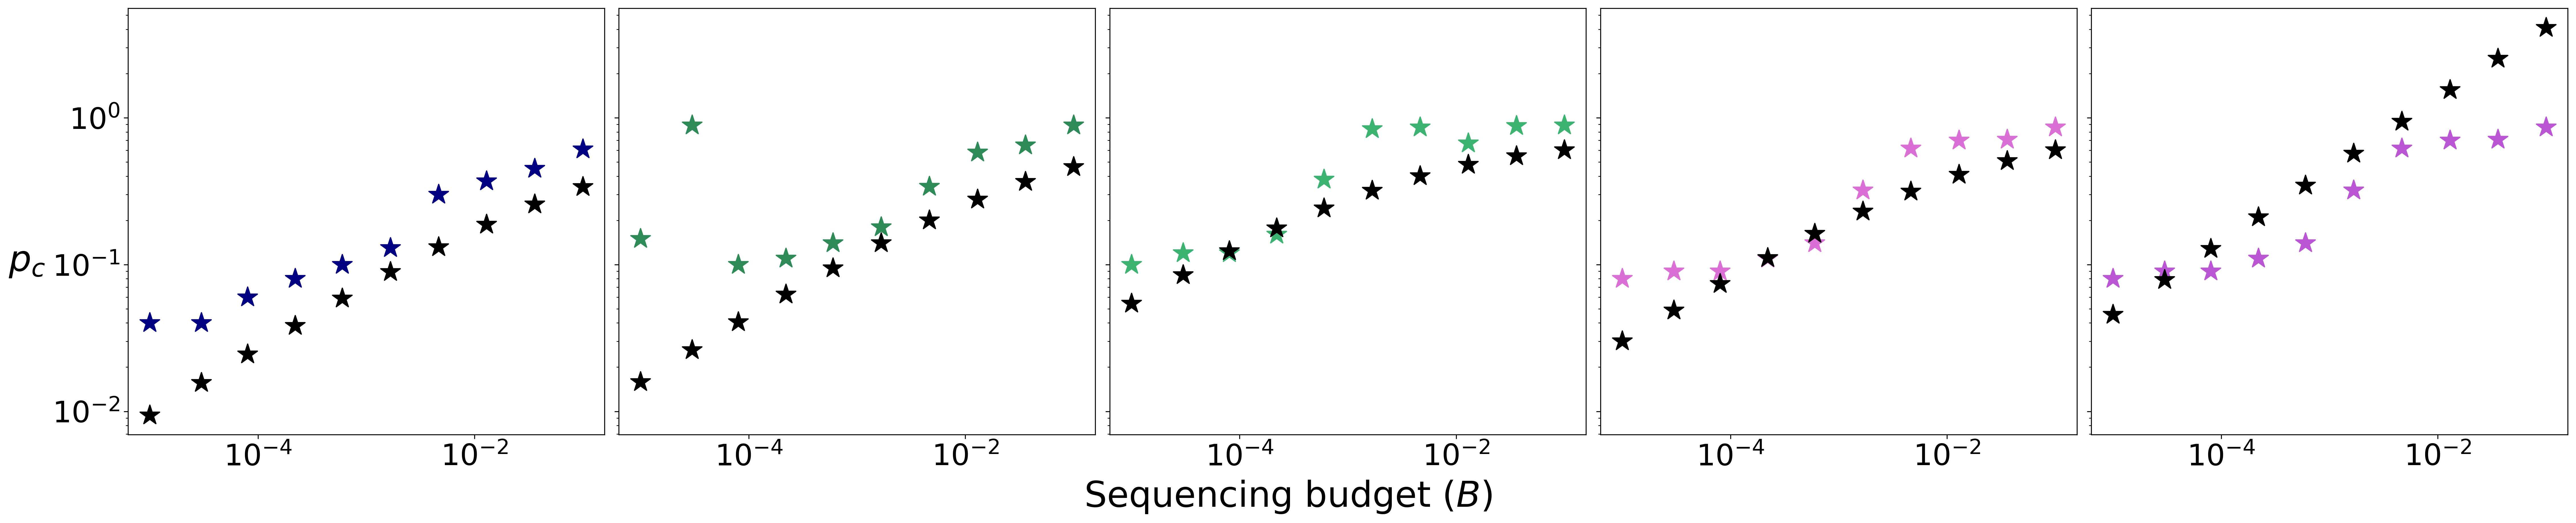

In [ ]:
# color differently budgets that demonstrate a tradeoff and those that don't

xcol = 'pc'

color_cell_better = 'indianred'
color_read_better = 'darkslateblue'
fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True)

ticksize = 25
for dataset, L_tradeoff in L_tradeoff_dict.items():

    tl = plot_loc[dataset]

    model_read = model_read_dict[dataset]
    model_cell = model_cell_dict[dataset]

    L_grp = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))

    pc_min = L_tradeoff['pc'].min()
    pc_max = L_tradeoff['pc'].max()

    # plot predicted min
    emp_min = compute_emp_min(L_tradeoff)
    Bs_inrange = emp_min['B'].values
    
    pc_min_pred = T.opt.get_pc_min_pred(model_read=model_read, model_cell=model_cell, B=Bs_inrange)
            
    ax[tl].scatter(emp_min['B'], emp_min['pc'], color=colors[dataset], s=300, marker='*')
    ax[tl].scatter(Bs_inrange, pc_min_pred, color='black', s=300, marker='*')
    ax[tl].set_xscale('log')
    ax[tl].set_yscale('log')
    ax[tl].tick_params(axis='y', labelsize=ticksize)
    ax[tl].tick_params(axis='x', labelsize=ticksize)
    

labelsize = 30
ylabel = r'$p_c$'
xlabel = r'Sequencing budget ($B$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_pred_min.png'))

In [ ]:
# df = pd.DataFrame({'B': L_tradeoff['B'].unique(), 'pc_min': pc_min, 'pc_max': pc_max})
# df['pt_min'] = df['B'] / df['pc_min']
# df['pt_max'] = df['B'] / df['pc_max']

# df['pred_cell_err_at_pc_min'] = model_cell.predict(np.log(df[['pc_min']]))
# df['pred_read_err_at_pc_min'] = model_read.predict(np.log(df[['pt_min']]))
# df['pred_cell_err_at_pc_max'] = model_cell.predict(np.log(df[['pc_max']]))
# df['pred_read_err_at_pc_max'] = model_read.predict(np.log(df[['pt_max']]))

# df['to_reads'] = df['pred_read_err_at_pc_min'] > df['pred_cell_err_at_pc_min']
# df['to_cells'] = df['pred_cell_err_at_pc_max'] > df['pred_read_err_at_pc_max']

In [ ]:
# from scipy.spatial.distance import cdist

# fig, ax = plt.subplots(2,two_ncols, figsize=(6*two_ncols,2*6))

# for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
#     tl = two_loc[traj_desc]
#     emp_min = compute_emp_min(L_tradeoff)
#     pred_cell_greater = compute_pred_cell_greater(L_tradeoff)
#     emp_min['idx B'] = emp_min['B'].apply(lambda x: np.where(pred_cell_greater.index == x)[0][0])
#     emp_min['idx pc'] = emp_min['pc'].apply(lambda x: np.where(pred_cell_greater.columns == x)[0][0])
    
#     sns.heatmap(pred_cell_greater, ax=ax[tl], fmt='.4f')
#     # ax.scatter(emp_min.loc[0,'pc'], emp_min.loc[0,'B'], marker='*', s=100, color='red') 
#     ax[tl].scatter(emp_min.loc[:,'idx pc'] + 0.5, emp_min.loc[:,'idx B'] + 0.5, marker='*', s=100, color='red') 

#     B1 = emp_min.iloc[0]['B']
#     nc1 = emp_min.iloc[0]['pc']
#     B2 = emp_min.iloc[-1]['B']
#     nc2 = emp_min.iloc[-1]['pc']

#     # v = T.opt.infer_optimal_nc(emp_min['B'].values, B1, nc1, B2, nc2, traj_type='complex')
#     # if v is not None:
#     #     v = v.real
#     #     anchors = pred_cell_greater.columns.values
#     #     emp_min['idx pc lambert'] = cdist(v.reshape(-1,1),anchors.reshape(-1,1)).argmin(1) 

#     #     ax[tl].scatter(emp_min.loc[:,'idx pc lambert'] + 0.2, emp_min.loc[:,'idx B'] + 0.5, marker='*', s=100, color='yellow') 


#     model_read = model_read_dict[traj_desc]
#     model_cell = model_cell_dict[traj_desc]
#     a = model_read.intercept_.take(0)
#     b = model_read.coef_.take(0)
#     c = model_cell.intercept_.take(0)
#     d = model_cell.coef_.take(0)
#     A = (a-c)/(d+b)
#     C = b / (d+b)
#     pc_min_pred = np.exp(A)*np.power(emp_min['B'].values,C)

#     anchors = pred_cell_greater.columns.values
#     emp_min['idx pc pred'] = cdist(pc_min_pred.reshape(-1,1), anchors.reshape(-1,1)).argmin(1) 

#     ax[tl].scatter(emp_min.loc[:,'idx pc pred'] + 0.2, emp_min.loc[:,'idx B'] + 0.5, marker='*', s=100, color='pink') 


#     ax[tl].set_title(traj_desc)

# plt.suptitle('Predictions of minimum', fontsize=20)
# plt.tight_layout()

# # background heatmap, prediction where cell error is greater than read error
# # lines which are all black or all bazz are not expecte to have a tradeoff (at least in this regime) 
# # stars show the empirical  minimums

## Pilot experiments

In [ ]:
# # read L_read
# L_read_pilot_dict = {}
# model_read_pilot_dict = {}

# L_cell_pilot_dict = {}
# model_cell_pilot_dict = {}

# for dataset in datasets:
#     L_read = pd.read_csv(os.path.join(outdir, f'{dataset}_pilot_pt0.1_L_reads.csv'), index_col=0)
#     L_read = L_read.drop(L_read[L_read['l1'].isna()].index)
#     L_read_pilot_dict[dataset] = L_read
    
#     # save fit of reconstruction error
#     model_read = linear_model.LinearRegression()
#     model_read.fit(L_read[['log pt']], L_read['l1'])
#     model_read_pilot_dict[dataset] = model_read

#     L_cell = pd.read_csv(os.path.join(outdir, f'{dataset}_pilot_pt0.1_L_cells.csv'), index_col=0)
#     L_cell_pilot_dict[dataset] = L_cell
    
#     # save fit of reconstruction error
#     model_cell = linear_model.LinearRegression()
#     model_cell.fit(L_cell[['log pc']], L_cell['l1'])
#     model_cell_pilot_dict[dataset] = model_cell


FileNotFoundError: [Errno 2] No such file or directory: '../output/linear_rep0_pilot_pt0.1_L_reads.csv'

a: -0.015561129305476984, b: 0.031011637377873966, $\alpha$: 0.01939055598627559, $\beta$: 0.015079858528230431
Blow: 0.0027090655673456224, Bhigh: 0.2724634778955268
a: 0.04050130999435356, b: 0.026785243367062218, $\alpha$: 0.015228749615779719, $\beta$: 0.042266656365377436
Blow: 0.0018191257555562118, Bhigh: 1.9023754112351414
a: 0.00802722755505375, b: 0.02888547284440313, $\alpha$: 0.06405136454288719, $\beta$: 0.04269710442707839
Blow: 0.0002750205952344239, Bhigh: 0.1077097851539444
a: 0.005707772738089173, b: 0.03092192620176934, $\alpha$: 0.058553894120897856, $\beta$: 0.029874866814953247
Blow: 0.0007169007089877234, Bhigh: 0.14397157333896005
a: -0.007499751552794975, b: 0.024947012887160856, $\alpha$: 0.061254766853724954, $\beta$: 0.03603775751993215
Blow: 6.549038089943706e-05, Bhigh: 0.04779198208545364


Text(0.02, 0.5, '$p_c$')

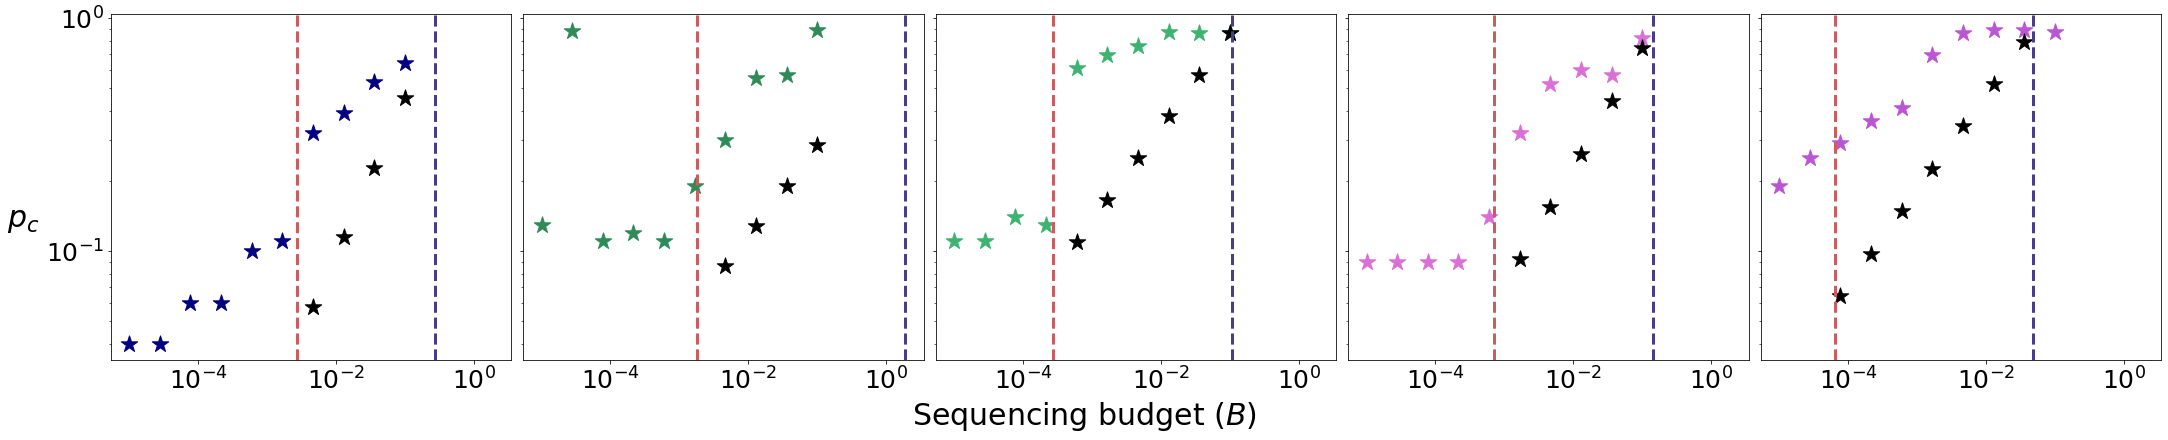

In [ ]:
# # color differently budgets that demonstrate a tradeoff and those that don't
# plot_std = 0
# xcol = 'pc'
# color_cell_better = 'indianred'
# color_read_better = 'darkslateblue'
# fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True)

# ticksize = 25
# for dataset, L_tradeoff in L_tradeoff_dict.items():

#     tl = plot_loc[dataset]

#     model_read = model_read_pilot_dict[dataset]
#     model_cell = model_cell_pilot_dict[dataset]

#     a = model_read.intercept_.take(0)
#     b = -model_read.coef_.take(0)
#     alpha = model_cell.intercept_.take(0)
#     beta = -model_cell.coef_.take(0)

#     A = (a - alpha) / b
#     C = (beta+b) / b

#     print(rf'a: {a}, b: {b}, $\alpha$: {alpha}, $\beta$: {beta}')

#     L_grp = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))

#     # nc = trajs[dataset].ncells
#     # # pc_min = 1e-4; pc_max = 1 - pc_min
#     # pc_min = 20 / nc; pc_max = 1 - pc_min
#     pc_min = L_tradeoff['pc'].min()
#     pc_max = L_tradeoff['pc'].max()
#     # B_low = np.exp(((beta+b) * np.log(pc_min) + a - alpha) / b)
#     B_low = np.exp(A)*pc_min**C
#     # B_high = np.exp(((beta+b) * np.log(pc_max) + a - alpha) / b)
#     B_high = np.exp(A)*pc_max**C
    
#     print(f'Blow: {B_low}, Bhigh: {B_high}')

#     # plot limits
#     ax[tl].axvline(x=B_low, color=color_cell_better, linewidth=3, linestyle='--')
#     ax[tl].axvline(x=B_high, color=color_read_better, linewidth=3, linestyle='--')

#     # plot empirical mins
#     # plot predicted min
#     emp_min = compute_emp_min(L_tradeoff)
#     # emp_min['log B'] = np.log(emp_min['B'])
#     # pred_cell_greater = compute_pred_cell_greater(L_tradeoff)
#     idx_b = (emp_min['B'] > B_low) & (emp_min['B'] < B_high) 
#     Bs_inrange = emp_min.loc[idx_b, 'B'].values
#     A = -(a-alpha)/(beta+b)
#     C = b / (beta+b)
#     pc_min_pred = np.exp(A)*np.power(Bs_inrange, C)
            
#     ax[tl].scatter(emp_min['B'], emp_min['pc'], color=colors[dataset], s=300, marker='*')
#     ax[tl].scatter(Bs_inrange, pc_min_pred, color='black', s=300, marker='*')
#     ax[tl].set_xscale('log')
#     ax[tl].set_yscale('log')
#     ax[tl].tick_params(axis='y', labelsize=ticksize)
#     ax[tl].tick_params(axis='x', labelsize=ticksize)
    

# labelsize = 30
# ylabel = r'$p_c$'
# xlabel = r'Sequencing budget ($B$)'
# fig.supxlabel(xlabel, fontsize=labelsize)
# fig.supylabel(ylabel, fontsize=labelsize, rotation=0)
